## Scale resolution

In [48]:
import aplpy
from astropy.io import fits
from astropy import wcs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
HDU = fits.open('/Users/robitaij/postdoc/Planck/HFI_tau353_polaris_6x_cut.fits')
imP = HDU[0].data / 1.2e-26
hdP = HDU[0].header
resoP = hdP['CDELT2'] * 60.
imP -= np.mean(imP)

HDU2 = fits.open('/Users/robitaij/postdoc/Herschel/Gould Belt/HGBS_polaris_cdens_rot_rebin_cut.fits')
imH = HDU2[0].data
hdH = HDU2[0].header
resoH = hdH['CDELT2'] * 60.
imH -= np.mean(imH)

In [3]:
from wavan import fan_trans
from astropy import wcs
from rebin import congrid
from scipy import interpolate

In [4]:
wtH, S11aH, wav_kH, S1aH, qH = fan_trans(imH, reso=resoH, q=0, qdyn=False, apodize= 0.98, arrdim = np.array([950,950]))
wtP, S11aP, wav_kP, S1aP, qP = fan_trans(imP, scales=wav_kH[0:9], reso=resoP, q=0, qdyn=False, apodize= 0.98, arrdim = np.array([800,800]))

950 950
800 800


In [5]:
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers.npy',wtH)

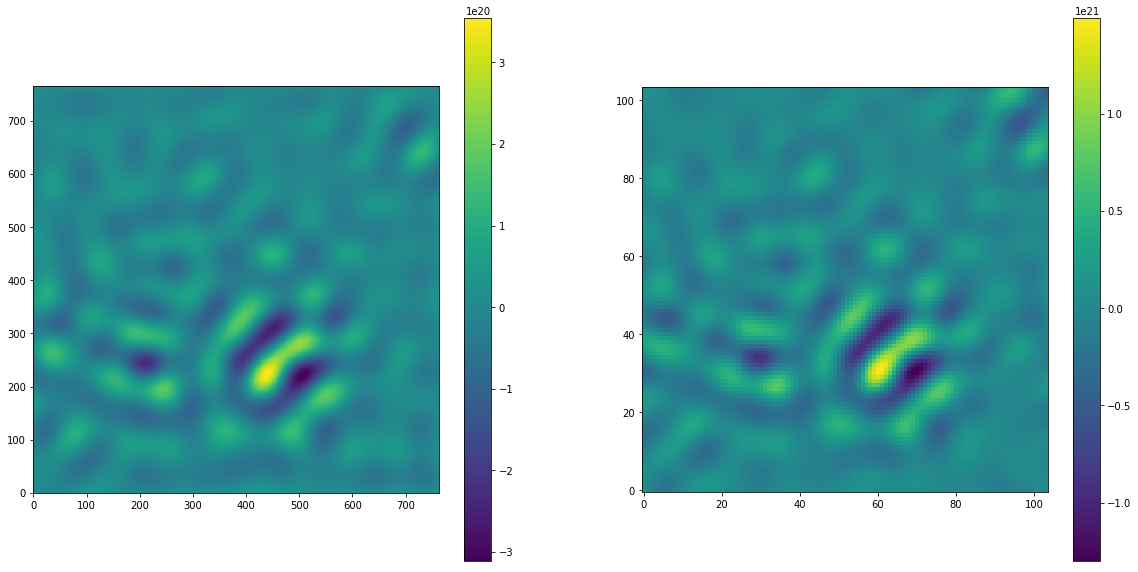

In [164]:
MP = wav_kP.size
MH = wav_kH.size

wP = wcs.WCS(hdP,HDU)
wH = wcs.WCS(hdH,HDU2)

wx0H, wy0H = wH.all_pix2world(0,0,0)
x0P, y0P = wP.all_world2pix(wx0H, wy0H,0)

wx1H, wy1H = wH.all_pix2world(HDU2[0].data.shape[1]-1,HDU2[0].data.shape[0]-1,0)
x1P, y1P = wP.all_world2pix(wx1H, wy1H,0)

scale = 8

figure(figsize=(20,10))
subplot(1,2,1)
imshow(wtH[scale,:,:].real,origin='below')
plt.colorbar()

subplot(1,2,2)
#imshow(wtP[2*M+scale,:,:].real,origin='below')
imshow(wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].real,origin='below')
plt.colorbar()

(719, 716)


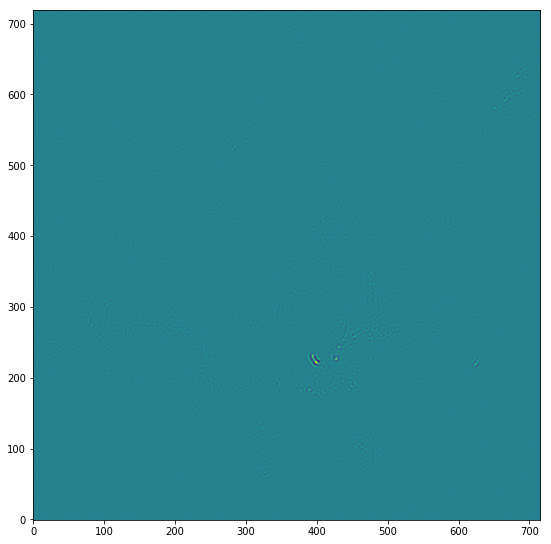

In [176]:
scale = 18

ko = 5.336

nxbinH = np.round(ko * imH.shape[1] * wav_kH[scale] *resoH)+1
nybinH = np.round(ko * imH.shape[0] * wav_kH[scale] *resoH)+1

imHbin = congrid(wtH[scale,:,:].real,(nybinH,nxbinH),method='linear',centre=True)

print imHbin.shape

#nxbinP = np.round(ko * (x1P-x0P) * wav_kP[scale] *resoP)
#nybinP = np.round(ko * (y1P-y0P) * wav_kP[scale] *resoP)

#imPbin = congrid(wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].real,(nybinP,nxbinP),method='linear',centre=True)

figure(figsize=(20,10))
subplot(1,2,1)
imshow(imHbin,origin='below')

#subplot(1,2,2)
#imshow(wtP[2*M+scale,:,:].real,origin='below')
#imshow(imPbin,origin='below')

hdpix = hdH.copy()
w = wcs.WCS(hdH)

hdpix['NAXIS1'] = nxbinH
hdpix['NAXIS2'] = nybinH
hdpix['CDELT1'] = hdH['CDELT1'] * imH.shape[1]/nxbinH
hdpix['CDELT2'] = hdH['CDELT2'] * imH.shape[1]/nxbinH
hdpix['CRVAL1'] = w.all_pix2world([[0,0]],0)[0,0]
hdpix['CRVAL2'] = w.all_pix2world([[0,0]],0)[0,1]
hdpix['CRPIX1'] = 0
hdpix['CRPIX2'] = 0
hdpix['RA'] = w.all_pix2world([[0,0]],0)[0,0]
hdpix['DEC'] = w.all_pix2world([[0,0]],0)[0,1]
    
fits.writeto("/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers_scl4_pix.fits",imHbin,overwrite=True)

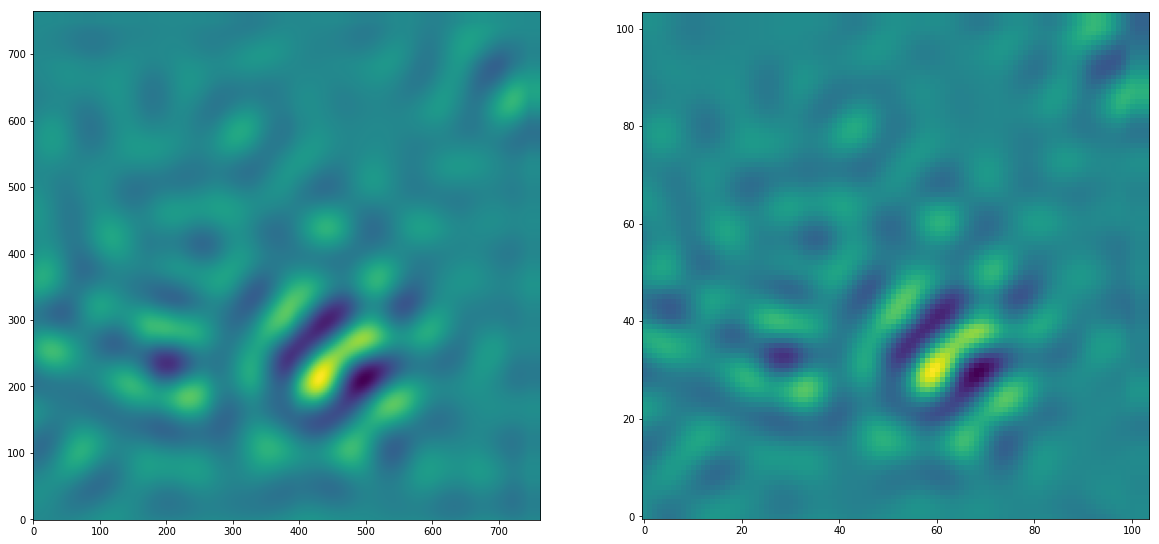

In [166]:
x = np.arange(0,nxbinH)
y = np.arange(0,nybinH)
xx, yy = np.meshgrid(x,y)
winterp = interpolate.interp2d(xx,yy,imHbin, kind='cubic')

xnew = np.linspace(0,nxbinH,imH.shape[1])
ynew = np.linspace(0,nybinH,imH.shape[0])
imHrec = winterp(xnew,ynew)

x = np.arange(0,nxbinP)
y = np.arange(0,nybinP)
xx, yy = np.meshgrid(x,y)
winterp = interpolate.interp2d(xx,yy,imPbin, kind='cubic')

xnew = np.linspace(0,nxbinP,np.int(x1P)-np.int(x0P))
ynew = np.linspace(0,nybinP,np.int(y1P)-np.int(y0P))
imPrec = winterp(xnew,ynew)

figure(figsize=(20,10))
subplot(1,2,1)
imshow(imHrec,origin='below')

subplot(1,2,2)
imshow(imPrec,origin='below')

(766, 763)
(104, 104)


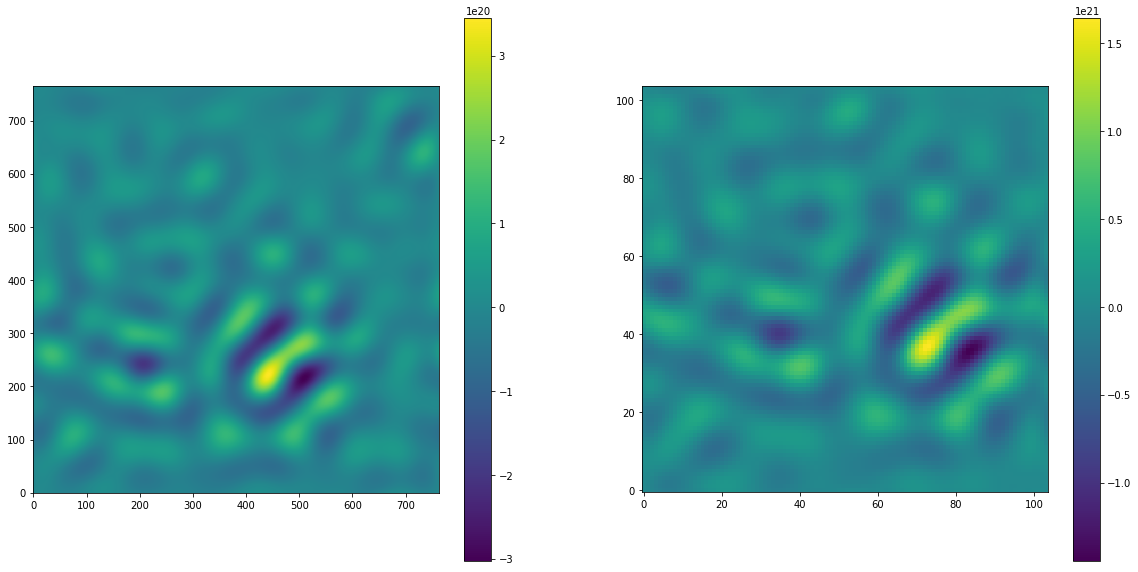

In [167]:
imHrec = rescale(imHbin,wav_kH[scale],wtH[scale,:,:].shape,resoH)

imPrec = rescale(imPbin,wav_kH[scale],wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].shape,resoP)

figure(figsize=(20,10))
subplot(1,2,1)
imshow(imHrec,origin='below')
plt.colorbar()

subplot(1,2,2)
imshow(imPrec,origin='below')
plt.colorbar()

print imHrec.shape
print imPrec.shape

fits.writeto("/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers_scl4.fits",wtH[scale,:,:].real,hdH,overwrite=True)
fits.writeto("/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers_rec_scl4.fits",imHrec,hdH,overwrite=True)

0.774455423977313
2.8205115437406816


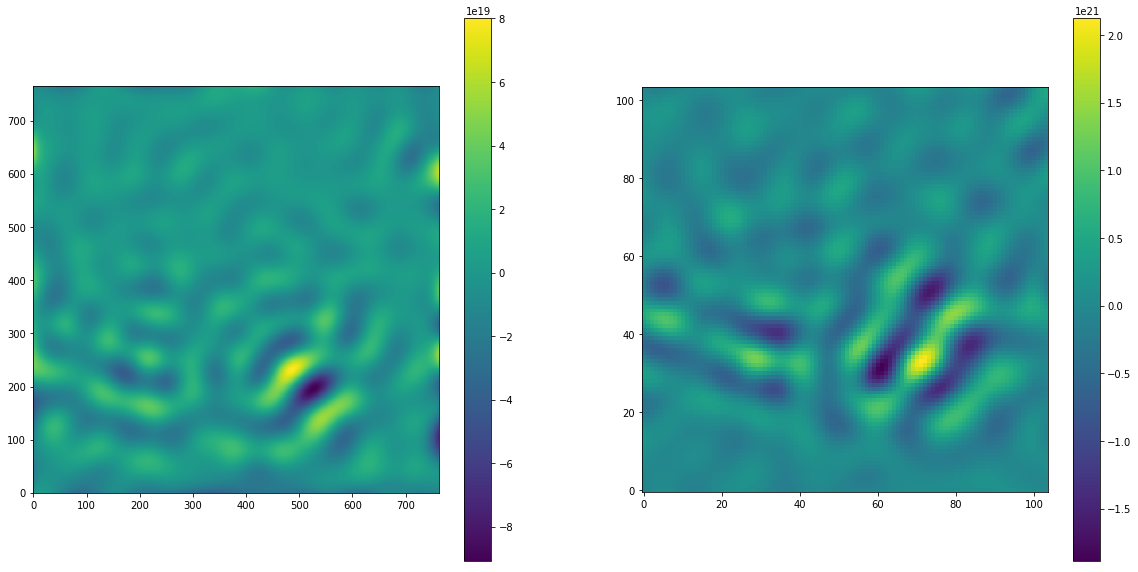

In [168]:
figure(figsize=(20,10))
subplot(1,2,1)
imshow(imHrec-wtH[scale,:,:].real,origin='below')
plt.colorbar()

subplot(1,2,2)
imshow(imPrec-wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].real,origin='below')
plt.colorbar()

print np.mean(imHrec/wtH[scale,:,:].real)
print np.mean(imPrec/wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].real)

In [149]:
q=[]
q=[1.9]*24
wtH, S11aH, wav_kH, S1aH, qH = fan_trans(imH, reso=resoH, q=q, qdyn=True, apodize= 0.98, arrdim = np.array([950,950]))

950 950


/anaconda2/lib/python2.7/site-packages/numpy/core/numerictypes.py:857: ComplexWarning: Casting complex values to real discards the imaginary part
  cast[key] = lambda x, k=key: array(x, copy=False).astype(k)


/anaconda2/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
INFO:astropy:Auto-setting vmin to -4.541e+20
INFO:astropy:Auto-setting vmax to  5.808e+20


INFO: Auto-setting vmin to -4.541e+20 [aplpy.core]
INFO: Auto-setting vmax to  5.808e+20 [aplpy.core]


INFO:astropy:Auto-setting vmin to -6.583e+20
INFO:astropy:Auto-setting vmax to  1.690e+21


INFO: Auto-setting vmin to -6.583e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.690e+21 [aplpy.core]


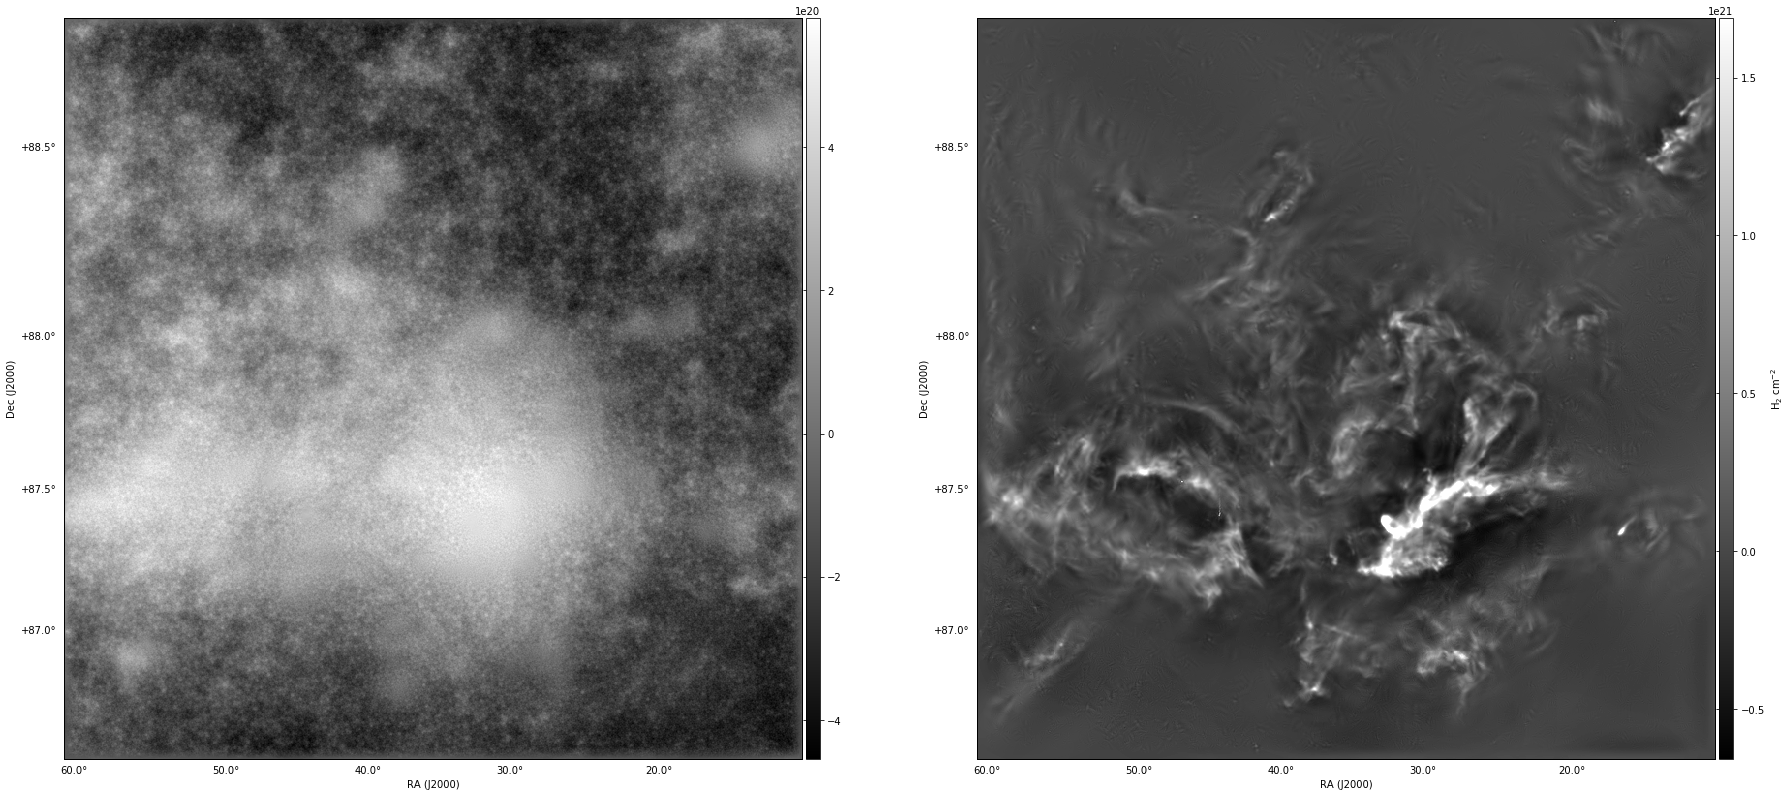

In [150]:
M = wav_kH.shape[0]

coherent = np.sum(wtH[M:2*M,:,:].real,axis=0)
Gaussian = np.sum(wtH[2*M:3*M,:,:].real,axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_pix_cohe.fits',\
            coherent.real,HDU2[0].header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_pix_gaussian.fits',\
            Gaussian.real,HDU2[0].header,overwrite=True)

fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_pix_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_pix_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [155]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
from bokeh.models import LogAxis, Range1d
output_notebook()

from powspec import powspec
from gauss_beam import gauss_beam

Loading BokehJS ...

In [156]:
#Apodization
tapper = apodize(imH.shape[0],imH.shape[1],0.98)
imt = imH *tapper
imr = padding(imt,950,950)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=resoH)

#Beam Power spectrum
#FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
FWHM = 36. / (60.*resoH)  #Beam size at 500 micron
beam = gauss_beam(FWHM,950,950,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=resoH)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=resoH, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
xmin = 0.003
xmax = 4.
ymin = 2 * 10**39
ymax = 3 * 10**45
f = figbok( x_axis_label="k [acrmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools, x_range=(xmin, xmax), y_range=(ymin, ymax))
f.line(tab_k, spec_k/spec_beamn, legend='Fourier')

S1an = np.copy(S1aH)

S1an[0,3:] = S1aH[0,3:]/BS1an[3:]
S1an[1,3:] = S1aH[1,3:]/BS1an[3:]
S1an[2,3:] = S1aH[2,3:]/BS1an[3:]

f.diamond(wav_kH, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_kH, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_kH, S1an[2,:], legend='Gaussian',color='red',line_width=5)
f.circle(wav_kH, S1an[2,:]+S1an[1,:], legend='Sum',color='green',line_width=2)

#Power law fit
coef,cov = np.polyfit(np.log(wav_kH[8:14]),np.log(S1an[2,8:14]),deg=1,cov=True)
yfit = np.exp(coef[1])*wav_kH**coef[0]

coef2,cov2 = np.polyfit(np.log(wav_kH[7:19]),np.log(S1an[1,7:19]),deg=1,cov=True)
yfit2 = np.exp(coef2[1])*wav_kH**coef2[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))
print "Power law coherent = ", coef2[0], np.sqrt(np.diag(cov2))

f.line(wav_kH, yfit, legend='Fit', line_dash='dashed')
f.line(wav_kH, yfit2, line_dash='dashed')

#Gaussian noise
f.line([np.min(tab_k),np.max(tab_k)], [S1an[2,18],S1an[2,18]], line_dash='dotted', color='red',legend="Gaussian noise")

print "Gaussian noise = ", S1an[2,18]

#Add axis in parsec
dist = 150.
pcmin = dist*np.tan((1./(60.*xmin))*(np.pi/180.))
pcmax = dist*np.tan((1./(60.*xmax))*(np.pi/180.))

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

f.legend.location = "top_right"

showbok(f)

Power law Gaussian =  -2.9027600039686403 [0.15086577 0.37177444]
Power law coherent =  -2.3958716822305997 [0.02852251 0.0596655 ]
Gaussian noise =  5.0409036546501785e+39


[1.9, 1.9, 1.9, 1.9, 1.7999999999999998, 1.9, 1.9, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9]
wav_H.shape[0]= 24


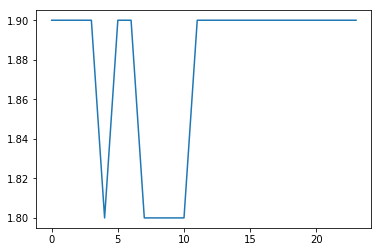

In [157]:
print q
print 'wav_H.shape[0]=',wav_kH.shape[0]

x = range(24)
plot(x,np.array(q).reshape(24))

In [158]:
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wav_k_pola_hers.npy',wav_kH)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/S1a_pola_hers.npy',S1aH)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers.npy',wtH)